Labels: 
0 - REAL 
1 - FAKE

1. IMPORTS

In [59]:
from collections import Counter
import re

import matplotlib.pyplot as plt
import pandas as pd

import nltk
from sklearn import model_selection
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

2. Data loading and preprocessing
Please note that all news without title of text are discarded.

In [60]:
data = pd.read_csv('/Users/ellen/OneDrive/Documents/Python/archive/WELFake_Dataset.csv')
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Check the labels first. I assumed that the description made a mistake of mislabeling fake news and real news because when I ran the wordcloud, the most frequent words in a fake news are suspicious since it involves a news outlet. To validate this assumpttion, I have a reference from the paper that used this dataset; it stated that there are, "72,134 news articles with 35,028 real and 37,106 fake news", which means by this we can count how many zeros and 1's out there and whoever is smaller between the two, we can assign it as a real news.

In [61]:
label_counts = data['label'].value_counts()

print("Number of 0s (Real):", label_counts[0])
print("Number of 1s (Fake):", label_counts[1])

Number of 0s (Real): 35028
Number of 1s (Fake): 37106


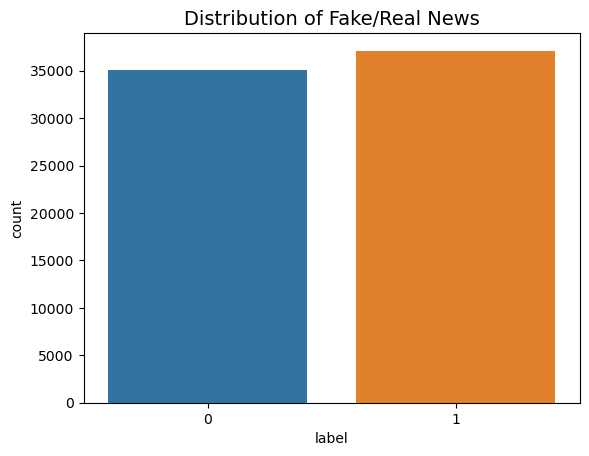

In [62]:
class_names = ['real', 'fake']
label_count = data.label.value_counts()

sns.barplot(x=label_count.index, y=label_count)
plt.title('Distribution of Fake/Real News', fontsize=14)
plt.show()


The graph indicates a substantial imbalance, with a higher frequency of 1 compared to 0. According to our reference, this suggests a prevalence of fake news over real news. Consequently, there is compelling evidence to associate 0 with real news and 1 with fake news.

In [63]:
data.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [65]:
data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

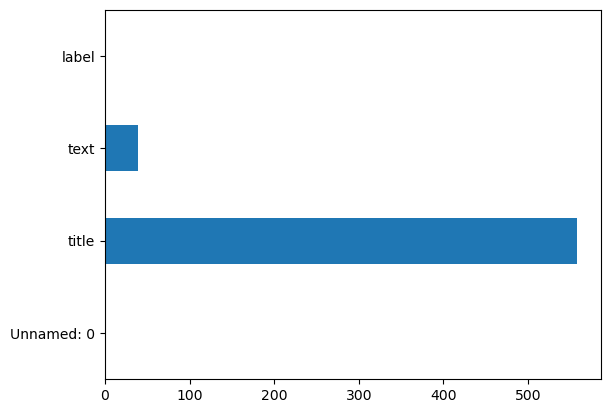

In [66]:
data.isnull().sum().plot(kind="barh")
plt.show()

In [67]:
data = data.fillna(' ') #fill empty rows with placeholder

In [68]:
data["title_text"] = data["title"] + data["text"] #combine the title and text
data["body_len"] = data["title_text"].apply(lambda x: len(x) - x.count(" ")) 
#Essentially, it's trying to measure the length of the text excluding the spaces.
data.head() #check

,Unnamed: 0,title,text,label,title_text,body_len
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,39
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668


Length of news

C:\Users\ellen\AppData\Local\Temp\ipykernel_7156\1987009079.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='label', y='body_len', data=data, ci=None)


<Axes: xlabel='label', ylabel='body_len'>

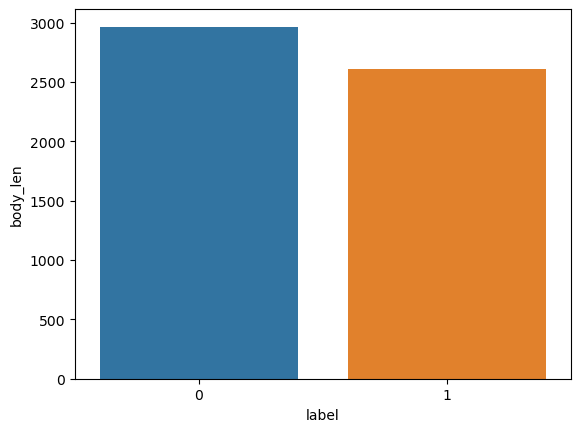

In [69]:
sns.barplot(x='label', y='body_len', data=data, ci=None)

In [70]:
#check
data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
title_text    0
body_len      0
dtype: int64

In [71]:
y, X = data.loc[:, 'label'], data.loc[:, data.columns != 'label']
print(f'Total number of observations: {len(X)}\n') #using f-string to include variables and expression within the string
print(f'Ratio of real and fake news:')
print(y.value_counts(normalize=True).rename({0: 'real', 1: 'fake'}))

Total number of observations: 72134

Ratio of real and fake news:
label
fake    0.514404
real    0.485596
Name: proportion, dtype: float64


In [72]:
# Create a set of English stopwords
stopwords_set = set(stopwords.words('english'))

# Initialize a Porter stemmer
porter_stemmer = PorterStemmer()

Explanatory data analysis is performed only on train set, which in this case consists of 80% of all available news chosen with random state of 42.

In [73]:
def remove_urls(text):
    URL_REGEX = r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    return re.sub(URL_REGEX, '', text)

def remove_non_alphabetical_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)
    
def stem_words(text):
    words = text.split()
    return ' '.join(
        [porter_stemmer.stem(word) for word in words if word not in stopwords_set]
    )

def transform_text(text):
    text = remove_urls(text)
    text = remove_non_alphabetical_characters(text)
    text = text.lower()
    text = stem_words(text)
    
    return text

In [74]:
data['transformed_title'] = data['title'].apply(transform_text)
data['transformed_text'] = data['text'].apply(transform_text)

data['content'] = data['transformed_title'] + ' ' + data['transformed_text']

In [81]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [82]:
X_train['transformed_title'] = X_train['title'].apply(transform_text)
X_train['transformed_text'] = X_train['text'].apply(transform_text)

3. Data visualization

The amount of available data is huge and impossible to analyze using traditional methods, with this, we will be using the wordcloud to view the most frequent words that occured on the dataset. With the help of wordcloud, it would be possible to compress information to a human-friendly plot.

In this section, we will be analyzing the following:

- all news' titles,
- all news' texts,

- titles of fake news,
- titles of real news,
- texts of fake news,
- texts of real news.

Goals:
- By this, we can get an idea on what words are frequently used on fake news and real news.

All news' titles

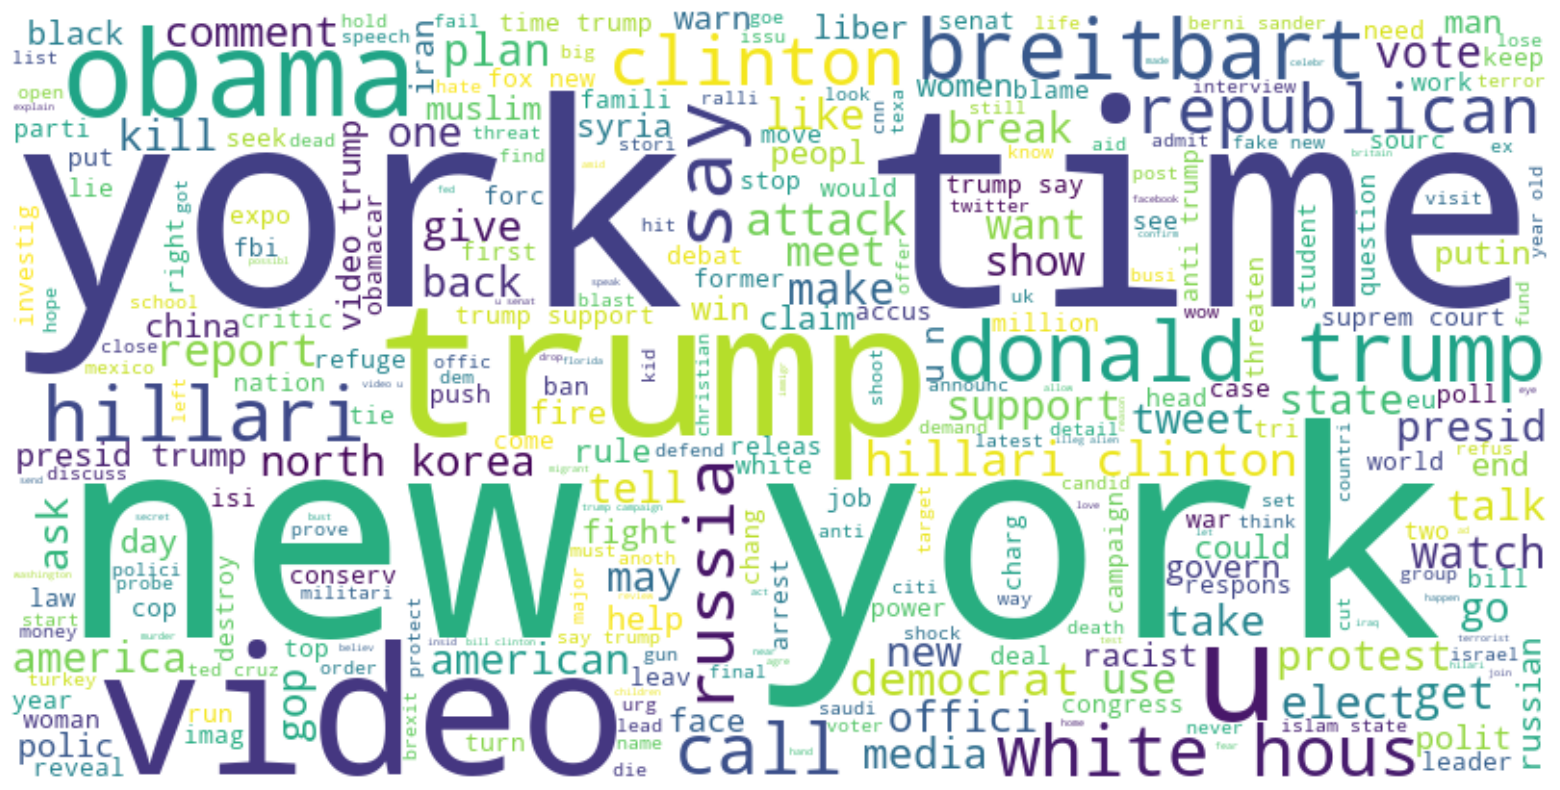

In [83]:
all_titles = ' '.join(title for title in X_train['transformed_title'])
wordcloud = WordCloud(
    background_color='white', 
    stopwords=stopwords_set, 
    max_words=300,
    width=800, 
    height=400,
).generate(all_titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Comments and spot-on observations:

- many of available news are from around presidential election period in the USA, which could make them unrepresentative in general,
- aside from inside-American issues such as elections, other countries such as Russia or North Korea seem to be a popular topic.
- Hence, we can say that this dataset focuses on the polical aspect

Titles of fake vs. real news

In [84]:
fake_news = X_train[y_train == 1] # 1 - FAKE
real_news = X_train[y_train == 0] # 0 - REAL

In [85]:
# Concatenate processed titles for fake news
fake_titles = ' '.join(title for title in fake_news['title'])

# Concatenate processed titles for true news
real_titles = ' '.join(title for title in real_news['title'])

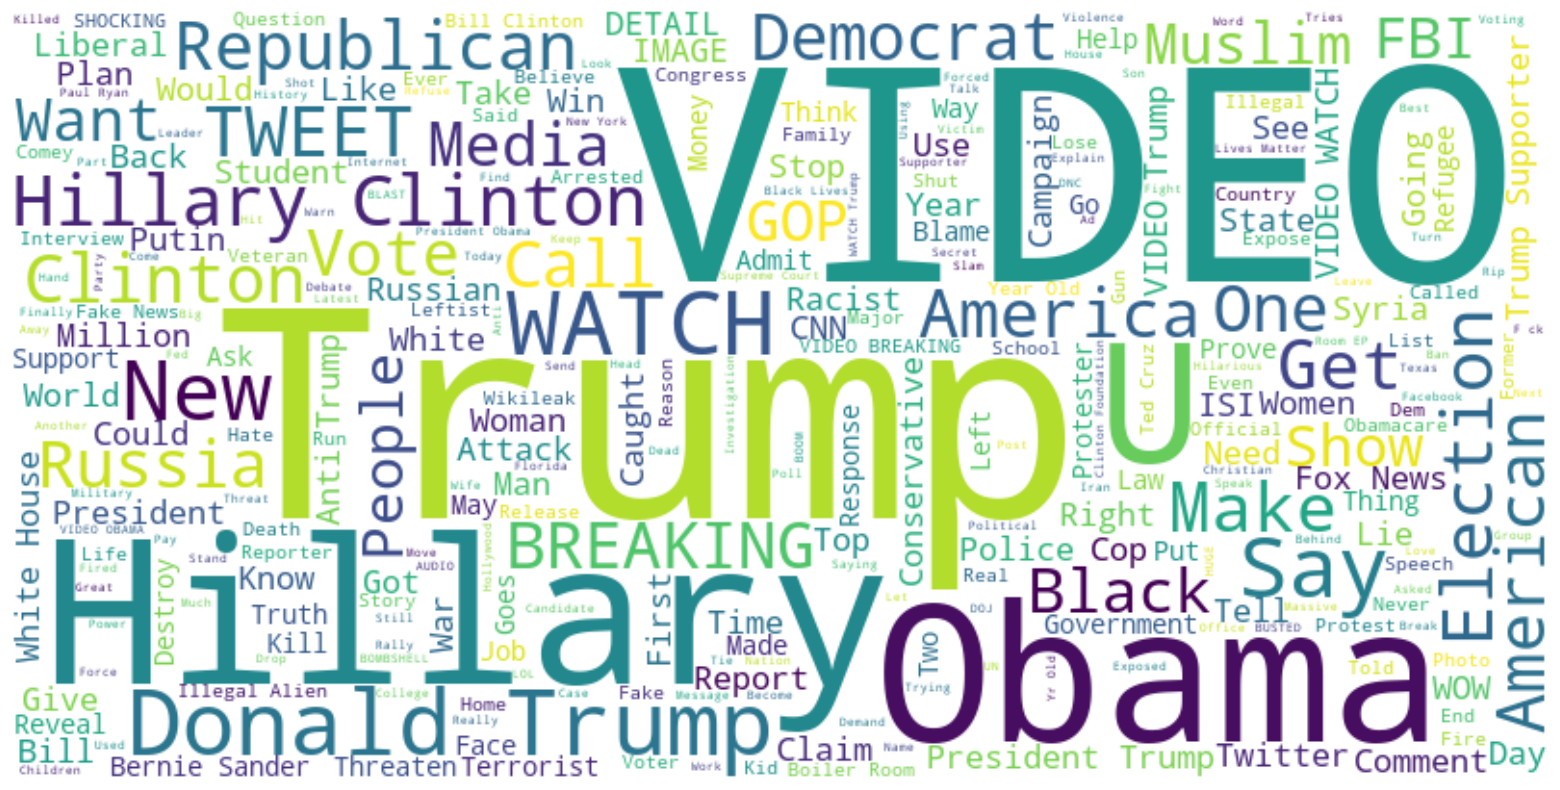

In [86]:
wordcloud = WordCloud(
    background_color='white', 
    stopwords=stopwords_set, 
    max_words=300,
    width=800, 
    height=400,
).generate(fake_titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

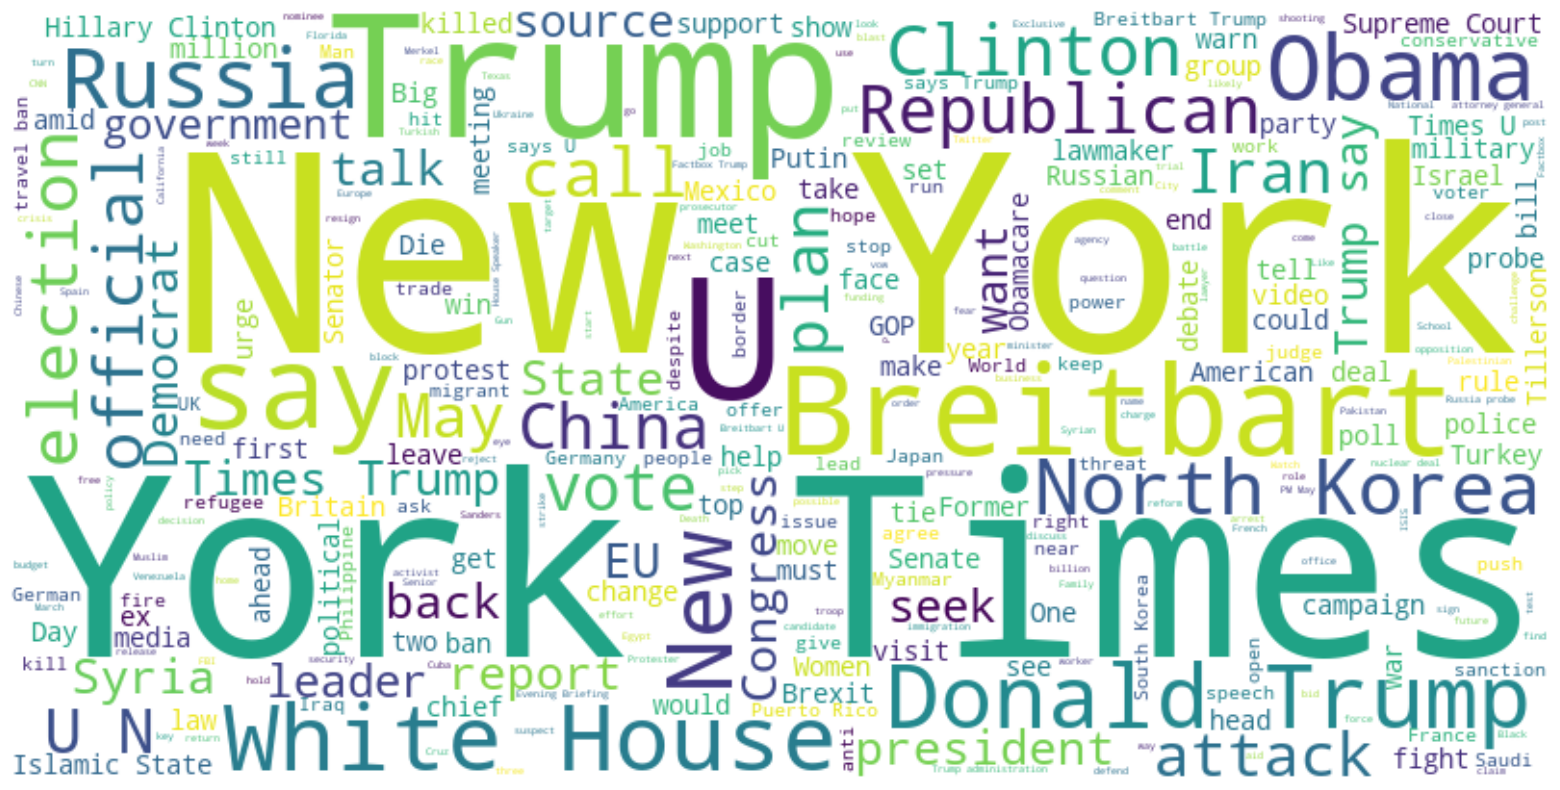

In [87]:
wordcloud = WordCloud(
    background_color='white', 
    stopwords=stopwords_set, 
    max_words=300,
    width=800, 
    height=400,
).generate(real_titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Comments and spot-on observations:

- both fake and real news often mention Donald Trump, Barrack Obama and Hillary Clinton,
- real news' titles seem to use "new york times", "breitbart" more often
- Fake news seem to have other politician's name in it. Moreover, "video".

In [88]:
video_fake, video_real = 0, 0
for title in fake_news['title']:
    if 'video' in title.lower():
        video_fake += 1
for title in real_news['title']:
    if 'video' in title.lower():
        video_real += 1

print(f"Number of times a fake news' title contains word 'video': {video_fake} out of {len(fake_news)}")
print(f"Number of times a real news' title contains word 'video': {video_real} out of {len(real_news)}")

Number of times a fake news' title contains word 'video': 7154 out of 29685
Number of times a real news' title contains word 'video': 175 out of 28022


In [89]:
nyt_fake, nyt_real = 0, 0
for title in fake_news['title']:
    if 'new york' in title.lower():
        nyt_fake += 1
for title in real_news['title']:
    if 'new york' in title.lower():
        nyt_real += 1

print(f"Number of times a fake news' title contains word 'new york': {nyt_fake} out of {len(fake_news)}")
print(f"Number of times a real news' title contains word 'new york': {nyt_real} out of {len(real_news)}")

Number of times a fake news' title contains word 'new york': 130 out of 29685
Number of times a real news' title contains word 'new york': 5134 out of 28022


In [90]:
nyt_fake, nyt_real = 0, 0
for title in fake_news['title']:
    if 'new york time' in title.lower():
        nyt_fake += 1
for title in real_news['title']:
    if 'new york time' in title.lower():
        nyt_real += 1

print(f"Number of times a fake news' title contains word 'new york time': {nyt_fake} out of {len(fake_news)}")
print(f"Number of times a real news' title contains word 'new york time': {nyt_real} out of {len(real_news)}")

Number of times a fake news' title contains word 'new york time': 60 out of 29685
Number of times a real news' title contains word 'new york time': 5016 out of 28022


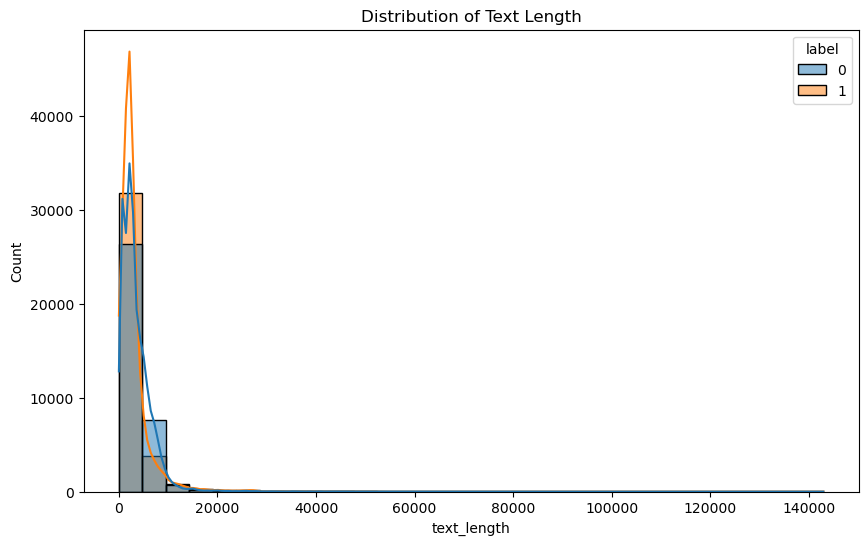

In [91]:
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data, x='text_length', hue='label', bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.show()

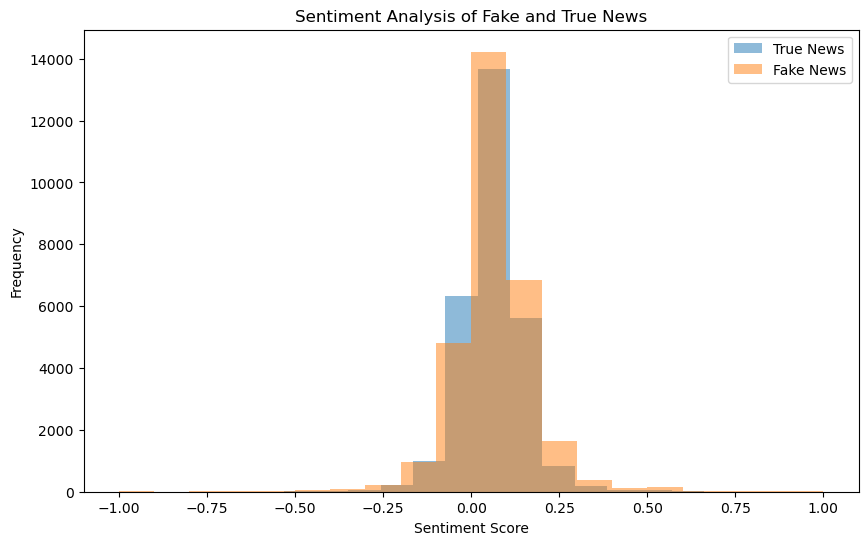

In [92]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt


# Convert X_train to a DataFrame (if it's not already)
X_train_data = pd.DataFrame(X_train, columns=X.columns)

# Calculate sentiment scores for each news article
X_train_data['sentiment_score'] = X_train_data['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Create a histogram of sentiment scores for fake and true news
plt.figure(figsize=(10, 6))
X_train_data[y_train == 0]['sentiment_score'].plot(kind='hist', alpha=0.5, bins=20, label='True News', legend=True)
X_train_data[y_train == 1]['sentiment_score'].plot(kind='hist', alpha=0.5, bins=20, label='Fake News', legend=True)
plt.title('Sentiment Analysis of Fake and True News')   
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Logistic Regression: solver = 'lbfgs' max_iter=1000 WE= CountVectorizer Model 
Data Preprocessing:
Transformed and cleaned the raw data with WE as the main feature 

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [102]:
X_train['content'] = X_train['transformed_title'] + ' ' + X_train['transformed_text']

In [103]:
X_test['transformed_title'] = X_test['title'].apply(transform_text)
X_test['transformed_text'] = X_test['text'].apply(transform_text)

X_test['content'] = X_test['transformed_title'] + ' ' + X_test['transformed_text']

In [104]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train['content'])
count_test = count_vectorizer.transform(X_test['content'])

In [105]:
# Train logistic regression model with a specific solver
logistic_regression_model = LogisticRegression(solver='lbfgs', max_iter=1000)  # Adjust solver and max_iter as needed
logistic_regression_model.fit(count_train, y_train)

LogisticRegression(max_iter=1000)

In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [107]:
# Make predictions on the test set
predicted = logistic_regression_model.predict(count_test)

# Evaluate the model
print(classification_report(y_test, predicted))
accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", round(accuracy * 100), '%')
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7006
           1       0.95      0.97      0.96      7421

    accuracy                           0.95     14427
   macro avg       0.95      0.95      0.95     14427
weighted avg       0.95      0.95      0.95     14427

Accuracy: 95 %
Accuracy: 0.9544603867747973


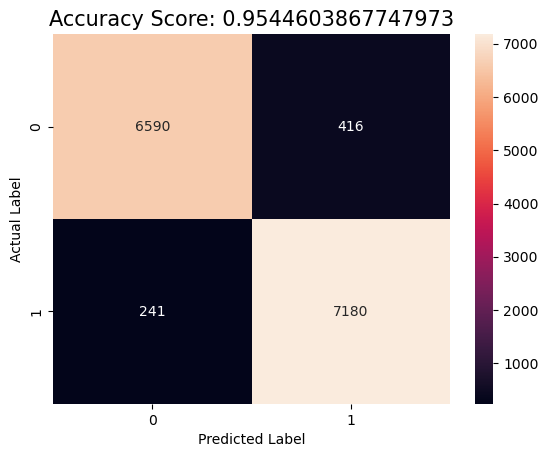

In [108]:
cm = confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot = True, fmt = '')
plt.ylabel('Actual Label');
plt.xlabel('Predicted Label');
# plt.title('Confusion Matrix')
all_sample_title  = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

Interpretation: 
- The texts doesn't give significant word that can be an indicator of true news. The words are just useless without its context. 
- Furthermore, by conducting implicitly a Named Entity Recognition(NER) by using wordcloud on the fake news, we can see the word "hillari clinton" and "donald trump" as mostly the topics of fake news articles.
- Notaby, there is trump on "fake news" and "real news".

Conclusion:
- By analyzing the Distribution of fake news and real news, we have uncovered that the metadata that was provided by kaggle was misleading and swapped the label of the fake and real news. 
- Now, by analyzing the frequency of words we can reveal patterns and the both the presence and the absence of words could
be an indicator of fake or real news.
- By analyzing the text, it seemed that there are politician that are  in which we could use a Named Entity Recognition to include on our feature space.
- Also, we can employ an n-gram model to analyze the relationship of words and add this to our feature space.
- Considering that mostly people with 